This notebook demonstrates how the magnetodisc data is distributed to determine how to normalize/scale the data for neural network training. 

# Dependencies

In [1]:
from pymagdisc.data.load_data import load_model
from pymagdisc.vis.plot_mdisc import plot_2d_cmp_exp_Pcold, plot_2d_cmp_exp_jphi
from pymagdisc.vis.plot_compare_contours_alpha import plot_compare_contours_alpha
from pymagdisc import config
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import warnings
from glob import glob
import pickle
import numpy as np
import util
import torch
from torchvision import transforms
warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 14})
%load_ext autoreload
%autoreload 2

# Load data

In [18]:
width = height = 512
samples_v2d_B = util.load_result(config.PATH_TO_DATA+'samples_v2d_B_rmu_512x512.pkl')
samples_v2d_B.shape

(15, 512, 512, 1)

# Transformation

## No transformation

(array([2.5814e+05, 1.6040e+03, 8.3600e+02, 5.1300e+02, 4.0100e+02,
        2.4800e+02, 1.8200e+02, 8.6000e+01, 6.6000e+01, 6.8000e+01]),
 array([3.45658681e-06, 1.99691150e-01, 3.99378844e-01, 5.99066538e-01,
        7.98754232e-01, 9.98441926e-01, 1.19812962e+00, 1.39781731e+00,
        1.59750501e+00, 1.79719270e+00, 1.99688040e+00]),
 <BarContainer object of 10 artists>)

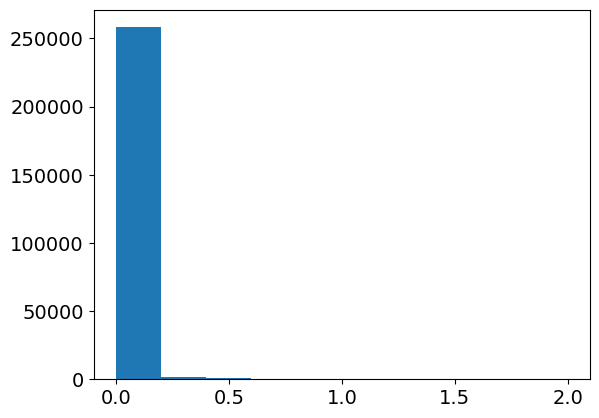

In [30]:
plt.hist(torch.tensor(samples_v2d_B)[0].flatten())

## Log transform data

In [19]:
samples_v2d_B_log = torch.log(torch.tensor(samples_v2d_B))
sample = samples_v2d_B_log[0]

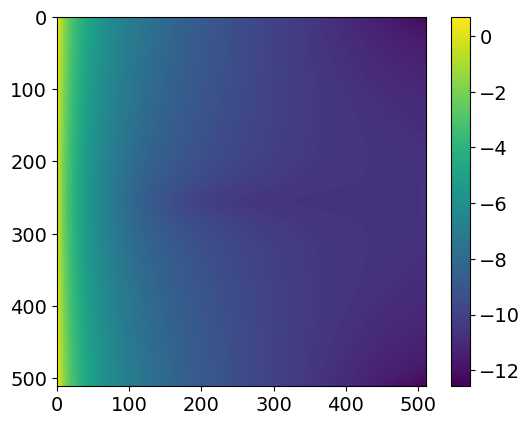

In [90]:
plt.imshow(sample)
plt.colorbar()

(array([  7824., 113064.,  59622.,  32324.,  19406.,  12096.,   7772.,
          5004.,   3156.,   1876.]),
 array([-12.53032713, -11.20813584,  -9.88594455,  -8.56375326,
         -7.24156197,  -5.91937068,  -4.59717939,  -3.2749881 ,
         -1.95279681,  -0.63060552,   0.69158577]),
 <BarContainer object of 10 artists>)

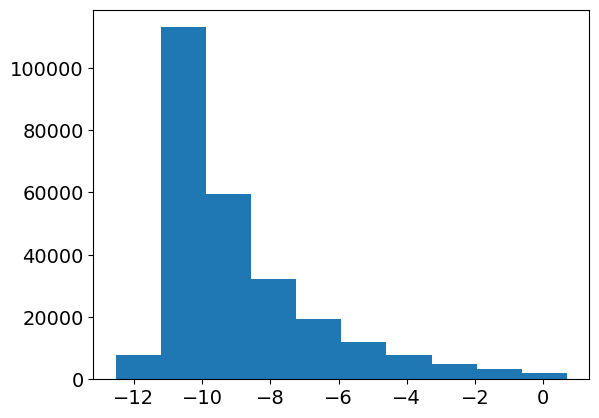

In [19]:
plt.hist(sample.flatten())

This distribution is slightly negatively skewed.

## Min-max scaling

In [77]:
# Min-Max Scaling
min_value = torch.min(sample)
max_value = torch.max(sample)
sample_scaled = (sample - min_value) / (max_value - min_value)


(array([  7694., 113120.,  59970.,  32348.,  19330.,  12036.,   7688.,
          4974.,   3138.,   1846.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

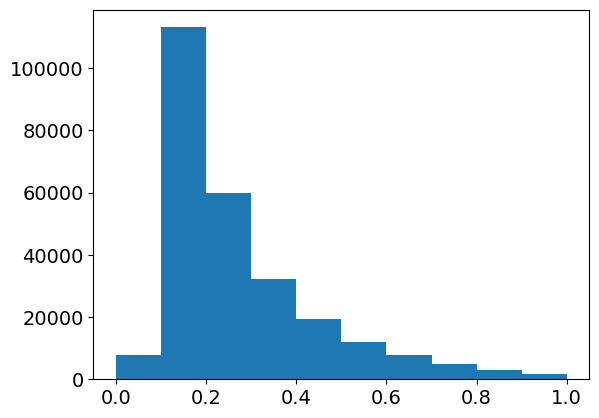

In [15]:
plt.hist(sample_scaled.flatten())

## z-score standardization

In [78]:
# Z-Score Standardization
mean = torch.mean(sample)
std = torch.std(sample)
sample_standardized = (sample - mean) / std
print(f"mean={mean}, std={std}")

# You can also use the transforms.Normalize() from torchvision (can be combined with other transfomrations)
#standardize = transforms.Normalize(mean=[mean], std=[std])
#sample_standardized = normalize(sample)

mean=-8.924701956259575, std=2.288442977309358


(array([  7694., 113120.,  59970.,  32348.,  19330.,  12036.,   7688.,
          4974.,   3138.,   1846.]),
 array([-1.59520119, -1.01547012, -0.43573904,  0.14399203,  0.72372311,
         1.30345418,  1.88318526,  2.46291634,  3.04264741,  3.62237849,
         4.20210956]),
 <BarContainer object of 10 artists>)

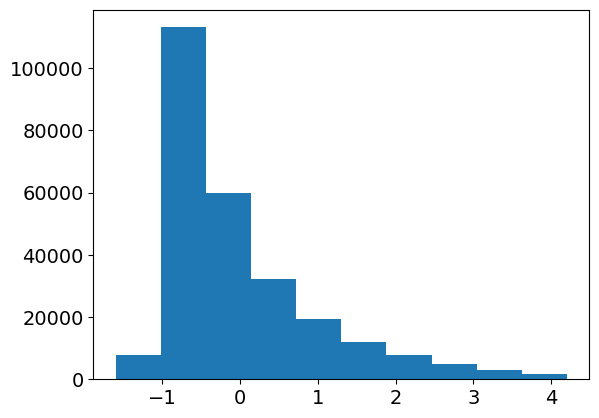

In [27]:
plt.hist(sample_standardized.flatten())

# Discussion

By applying a log transformation before normalization, you can effectively handle values spanning multiple orders of magnitude and improve the distribution of the data, which is needed for training neural networks.

Since there is no physical maximum in the quantities of interest, it would be more suitable to use z-score standarization on the log data. 

# Calculating mean and std of whole dataset

Since the entire dataset is ~1.4 TB, which is too large to fit in RAM. Computing the mean and std of the entire dataset directly is not feasible. Instead, we can approximate the mean and std by calculating by iterating through the dataset (aka online mean estimation; e.g. Welford's method).

In [12]:
from torch.utils.data import DataLoader
from mdiscnet.custom_dataset import CustomDataset
from mdiscnet.preprocess import online_mean_std

# Load dataset
data_path = './mdiscnet/data/MDISC/small_dataset/samples_v2d_B_rmu_512x512.pkl'
labels_path = './mdiscnet/data/MDISC/small_dataset/samples_target.pkl'
width = 512
# transforms.ToTensor assumes input dimensions (H x W x C)
transform=transforms.Compose([transforms.ToTensor(),
                              torch.log,
                              transforms.Normalize(mean=[-8.9598], std=[2.2902]), # comment out this line, if want to determine the mean and std of dataset
                             ])
dataset = CustomDataset(data_path=data_path, labels_path=labels_path, transform=transform)

In [13]:
mean, std = online_mean_std(dataset)

In [14]:
mean, std

(tensor(-8.9598), tensor(2.2902))

The above mean and std are similar to that of a single sample in the `z-score standarization` section.

In [21]:
# Apply this sample mean and standard deviation to standardize each sample
standardize = transforms.Normalize(mean=[mean], std=[std])

# load sample
samples_v2d_B_log = torch.log(torch.tensor(samples_v2d_B))
sample = samples_v2d_B_log[0]
sample_standardized = standardize(sample)

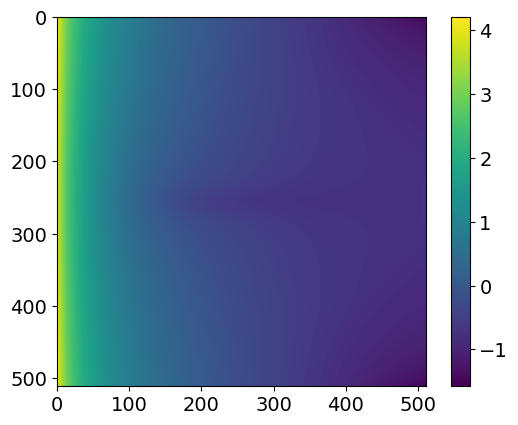

In [22]:
plt.imshow(sample_standardized)
plt.colorbar()